## Basic workflow for AL in Fink Stream with ML flow logging

The goal of this notebook is to explore how to set up an Active Learning Loop for the VRA in the Fink ZTF stream with ML flow logging.

We have added a `consumer.py` utility to the `finkvra` package so I should be able to poll the data. Then te question is how to string together the ML prediction, log its results, do the AL sampling, get the labels from a human eyeballer, log that in Ml flow and repeat. 


**Full worklow**

* 1) Poll the stream for initial N alerts 
* 2) Set up real and galactic models on the data
* 3) Initial training and predictions -> Log with ML Flow
* 4) Poll again for N alerts
* 5) Predict -> Log with ML Flow
* 6) AL strategy: choose samples and ask eyeballer for labels -> Log in ML Flow
* 7) Retrain -> Log ML Flow
* [...] Repeat

# This notebook

Get familiar with the data we poll from the stream. 
Noticed that I need to sherlock data to remove AGNs and SNe



## 1. Poll ZTF stream for initial alerts N=20

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from finkvra.utils import consumer as finkconsumer


In [2]:
finkconsumer.poll_n_alerts?

In [3]:
myconfig = {
    'bootstrap.servers': 'kafka-ztf.fink-broker.org:24499',
    'group.id': 'heloise_test6'
}
topics = ['fink_vra_ztf'] # the fink VRA filter I made with Julien in May 2025

In [4]:
finkconsumer.poll_n_alerts(myconfig, topics, n=50)

2025-05-30 11:47:25,384 [INFO] finkvra.utils.consumer.poll_n_alerts: Polling 50 alerts from topics: ['fink_vra_ztf']
2025-05-30 11:47:30,388 [INFO] finkvra.utils.consumer.poll_n_alerts: No alerts received in the last 5 seconds.


Note: the Data is saved to `~/Data/FinkZTFStream/` instead of being returned, and the `finkconsumer.poll_n_alerts` function isn't very verbose so hard to tell what's going on. 

- [x] **Add logging to** `finkconsumer.poll_n_alerts` 


### Reading the alerts from my local directory

In [10]:
data = pd.read_parquet('/home/stevance/Data/FinkZTFStream/20250529_081130_alerts.parquet')

In [11]:
data

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,lc_features_g,lc_features_r
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.73056983947754, 19.649499893188477, 19.653...","[20.168989181518555, 20.210899353027344, 20.04...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.0889855545874525, 'anderson_da...","{'amplitude': 0.04189712620773456, 'anderson_d..."
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.718433380126953, 19.744800567626953, nan, ...","[20.201236724853516, 20.265199661254883, 19.99...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.10481508251287153, 'anderson_d...","{'amplitude': 0.07152319243344074, 'anderson_d..."
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,"[60822.30150459986, 60795.25657409988, 60795.2...","[20.0477237701416, nan, 20.28849983215332, nan...","[20.356197357177734, 20.488500595092773, 20.41...","[1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1]","{'amplitude': 0.056522341237133844, 'anderson_...","{'amplitude': 0.008201653912088602, 'anderson_..."
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,"[60822.301041699946, 60796.298738399986, 60796...","[19.915971755981445, nan, nan, nan, 20.0750999...","[20.27997589111328, 20.667699813842773, 20.717...","[1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2]","{'amplitude': 0.036173002449437774, 'anderson_...","{'amplitude': 0.05823865295848485, 'anderson_d..."
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.7941837310791, nan, 19.776899337768555, 19...","[20.269792556762695, 20.584299087524414, 20.55...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.02279264101152023, 'anderson_d...","{'amplitude': 0.040600431117978175, 'anderson_..."
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,"[60822.30055559985, 60794.316689800005, 60794....","[20.09563636779785, nan, 20.090299606323242, 2...","[20.513275146484375, 20.359500885009766, 20.57...","[1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, ...","{'amplitude': 0.11523281604381097, 'anderson_d...","{'amplitude': None, 'anderson_darling_normal':..."
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.72616958618164, nan, nan, nan, nan, nan, n...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':..."
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,"[60822.29878470022, 60796.29603009997, 60796.3...","[20.124170303344727, nan, nan, nan, nan, nan, ...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':..."
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.779403686523438, nan, nan, nan, nan, nan, ...","[20.43389320373535, 20.7185001373291, 20.75889...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2]","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':..."
9,3068250212815010015,ZTF25aasgxxa,154.819456,39.860953,0.991996,"[60822.25021990016, 60796.26479170006, 60796.3...","[20.34264373779297, nan, nan, nan, nan, nan, n...","[20.27332878112793, 20.750099182128906, 20.578...","[2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, ...","{'amplitude': None, 'anderson_darling_normal':...","{'amplitude': 0.0, 'anderson_darling_normal': ..."


In [12]:
lasair_base_url = 'https://lasair-ztf.lsst.ac.uk/objects/'

https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt/ is an AGN

-> **I could use the Lasair API to grab the sherlock data** 

Then again we won't have a bgi repository of AGNs in first year of LSST so maybe not relying on that would be good.

In [13]:
fid2col_dict={1:'navy', 2:'orange'}

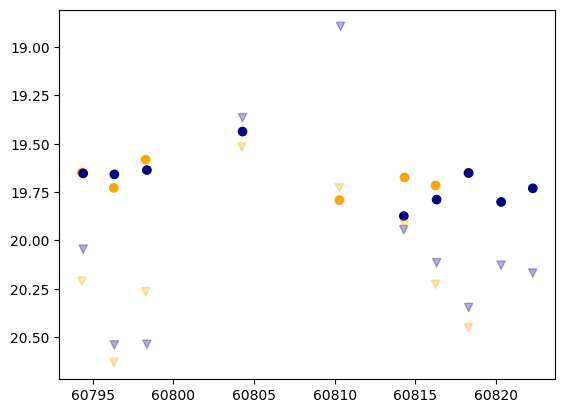

In [14]:
plt.scatter(data.iloc[0].mjd, data.iloc[0].mag, 
            c=[fid2col_dict[fid] for fid in data.iloc[0].fid])
plt.scatter(data.iloc[0].mjd, data.iloc[0].maglim, 
            c=[fid2col_dict[fid] for fid in data.iloc[0].fid], alpha=0.3, marker ='v')
plt.gca().invert_yaxis()

ZTF Gives **30 days history** in the packets. 

_Easy features I can calculate_
- N dets with mag brighter than non dets


_What features can I poach?_

The link https://github.com/astrolabsoftware/fink-science/tree/master/fink_science/ad_features is broken. **For now just do everything**


In [7]:
data.iloc[0]['lc_features_g']

{'amplitude': 0.0889855545874525,
 'anderson_darling_normal': 0.46326638170649537,
 'beyond_1_std': 0.2222222222222222,
 'chi2': 0.33593972251719717,
 'cusum': 0.33384228466873633,
 'inter_percentile_range_10': 0.13269743469322748,
 'kurtosis': 1.6779295399609637,
 'linear_fit_reduced_chi2': 0.27547956997842105,
 'linear_fit_slope': 0.0018460531551792265,
 'linear_fit_slope_sigma': 0.002118738228307318,
 'linear_trend': 0.0023707633108586345,
 'linear_trend_noise': 0.04740620596438159,
 'linear_trend_sigma': 0.0015132942911012998,
 'magnitude_percentage_ratio_20_10': 0.46396335090897806,
 'magnitude_percentage_ratio_40_5': 0.15540172247059275,
 'maximum_slope': 0.02908475906962211,
 'mean': 18.692279695203148,
 'mean_variance': 0.002757038799239993,
 'median': 18.680202192653496,
 'median_absolute_deviation': 0.02869608081787689,
 'median_buffer_range_percentage_10': 0.3333333333333333,
 'percent_amplitude': 0.09542628539689346,
 'skew': -0.8953212089680165,
 'standard_deviation': 0.05


#### As a first aproach I'm not going to calculate anything, I'm going to use what's natively in Fink

### Make `X` from the data table

In [8]:
lc_features_g_series = []
lc_features_r_series = []
context = [] # ra, dec, drb
for i in range(data.shape[0]):
    context.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g']))
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r']))

In [9]:
pd.DataFrame(lc_features_g_series)

,amplitude,anderson_darling_normal,beyond_1_std,chi2,cusum,inter_percentile_range_10,kurtosis,linear_fit_reduced_chi2,linear_fit_slope,linear_fit_slope_sigma,...,mean,mean_variance,median,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,skew,standard_deviation,stetson_K,weighted_mean
0,0.088986,0.463266,0.222222,0.335940,0.333842,0.132697,1.677930,0.275480,0.001846,0.002119,...,18.692280,0.002757,18.680202,0.028696,0.333333,0.095426,-0.895321,0.051535,0.863922,18.692437
1,0.104815,0.338368,0.428571,0.277137,0.235093,0.195766,-0.585756,0.332141,0.000265,0.005762,...,19.808331,0.003898,19.822715,0.047291,0.142857,0.141443,-0.813513,0.077209,0.876386,19.793494
2,0.056522,0.090277,0.500000,0.837440,0.345844,0.113045,1.128660,1.222776,-0.000588,0.002276,...,18.564091,0.002540,18.558406,0.026931,0.000000,0.067891,0.676402,0.047154,0.785021,18.564575
3,0.036173,0.238524,0.333333,0.113948,0.230920,0.070105,-1.557812,0.110558,0.001215,0.003404,...,18.947213,0.001509,18.940966,0.021199,0.000000,0.045864,0.451202,0.028593,0.890486,18.941424
4,0.022793,0.262392,0.428571,0.046836,0.368901,0.041417,-0.220678,0.045507,-0.000642,0.002775,...,19.033106,0.000807,19.030387,0.006586,0.142857,0.026963,0.457590,0.015368,0.797619,19.033655
5,0.115233,1.005658,0.111111,0.158097,0.327872,0.178572,2.840382,0.177144,0.000577,0.003667,...,19.606638,0.003855,19.565289,0.017679,0.444444,0.212786,1.720660,0.075589,0.811232,19.576824
6,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,19.726170,NaN,19.726170,0.000000,0.000000,0.000000,NaN,NaN,NaN,19.726170
7,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,19.981065,NaN,19.981065,0.000000,0.000000,0.000000,NaN,NaN,NaN,19.981065
8,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,17.685332,NaN,17.685332,0.000000,0.000000,0.000000,NaN,NaN,NaN,17.685332
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### There's quite a lot of NaN values there... Maybe should try to make my own dumb LC features after all

## N dets with mag brighter than non dets

In [10]:
ndets = sum(~pd.isna(data.iloc[0]['mag']))
nnondets = sum(pd.isna(data.iloc[0]['mag']))
dets_median = np.nanmedian(data.iloc[0]['mag'])
dets_std = np.nanstd(data.iloc[0]['mag'])

In [11]:
def vra_lc_feats(row):
    ndets = sum(~pd.isna(row['mag']))
    nnondets = sum(pd.isna(row['mag']))
    dets_median = np.nanmedian(row['mag'])
    dets_std = np.nanstd(row['mag'])
    return ndets, nnondets, dets_median, dets_std

In [12]:
feat_df = data.apply(lambda row: vra_lc_feats(row), axis=1, result_type='expand')
feat_df.columns = ['ndets', 'nnondets', 'dets_median', 'dets_std']
data = data.join(feat_df)

In [13]:
data

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,lc_features_g,lc_features_r,ndets,nnondets,dets_median,dets_std
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.73056983947754, 19.649499893188477, 19.653...","[20.168989181518555, 20.210899353027344, 20.04...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.0889855545874525, 'anderson_da...","{'amplitude': 0.04189712620773456, 'anderson_d...",16.0,2.0,19.666651,0.098708
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.718433380126953, 19.744800567626953, nan, ...","[20.201236724853516, 20.265199661254883, 19.99...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.10481508251287153, 'anderson_d...","{'amplitude': 0.07152319243344074, 'anderson_d...",14.0,4.0,19.748200,0.067737
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,"[60822.30150459986, 60795.25657409988, 60795.2...","[20.0477237701416, nan, 20.28849983215332, nan...","[20.356197357177734, 20.488500595092773, 20.41...","[1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1]","{'amplitude': 0.056522341237133844, 'anderson_...","{'amplitude': 0.008201653912088602, 'anderson_...",6.0,6.0,20.126862,0.261365
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,"[60822.301041699946, 60796.298738399986, 60796...","[19.915971755981445, nan, nan, nan, 20.0750999...","[20.27997589111328, 20.667699813842773, 20.717...","[1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2]","{'amplitude': 0.036173002449437774, 'anderson_...","{'amplitude': 0.05823865295848485, 'anderson_d...",9.0,7.0,20.021099,0.101441
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.7941837310791, nan, 19.776899337768555, 19...","[20.269792556762695, 20.584299087524414, 20.55...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.02279264101152023, 'anderson_d...","{'amplitude': 0.040600431117978175, 'anderson_...",12.0,5.0,19.791292,0.074670
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,"[60822.30055559985, 60794.316689800005, 60794....","[20.09563636779785, nan, 20.090299606323242, 2...","[20.513275146484375, 20.359500885009766, 20.57...","[1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, ...","{'amplitude': 0.11523281604381097, 'anderson_d...","{'amplitude': None, 'anderson_darling_normal':...",9.0,9.0,20.083000,0.094845
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.72616958618164, nan, nan, nan, nan, nan, n...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,19.726170,0.000000
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,"[60822.29878470022, 60796.29603009997, 60796.3...","[20.124170303344727, nan, nan, nan, nan, nan, ...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,20.124170,0.000000
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.779403686523438, nan, nan, nan, nan, nan, ...","[20.43389320373535, 20.7185001373291, 20.75889...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2]","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,15.0,19.779404,0.000000
9,3068250212815010015,ZTF25aasgxxa,154.819456,39.860953,0.991996,"[60822.25021990016, 60796.26479170006, 60796.3...","[20.34264373779297, nan, nan, nan, nan, nan, n...","[20.27332878112793, 20.750099182128906, 20.578...","[2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 

In [14]:
lc_features_g_series = []
lc_features_r_series = []
vra_features = [] # ra, dec, drb, 'ndets', 'nnondets', 'dets_median', 'dets_std'
for i in range(data.shape[0]):
    vra_features.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb', 'ndets', 'nnondets', 'dets_median', 'dets_std']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g']))
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r']))

In [15]:
X = pd.DataFrame(vra_features).join(pd.DataFrame(lc_features_g_series)).join(pd.DataFrame(lc_features_g_series), rsuffix='r_')

In [16]:
X

,candid,objectId,ra,dec,drb,ndets,nnondets,dets_median,dets_std,amplitude,...,meanr_,mean_variancer_,medianr_,median_absolute_deviationr_,median_buffer_range_percentage_10r_,percent_amplituder_,skewr_,standard_deviationr_,stetson_Kr_,weighted_meanr_
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,16.0,2.0,19.666651,0.098708,0.088986,...,18.692280,0.002757,18.680202,0.028696,0.333333,0.095426,-0.895321,0.051535,0.863922,18.692437
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,14.0,4.0,19.748200,0.067737,0.104815,...,19.808331,0.003898,19.822715,0.047291,0.142857,0.141443,-0.813513,0.077209,0.876386,19.793494
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,6.0,6.0,20.126862,0.261365,0.056522,...,18.564091,0.002540,18.558406,0.026931,0.000000,0.067891,0.676402,0.047154,0.785021,18.564575
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,9.0,7.0,20.021099,0.101441,0.036173,...,18.947213,0.001509,18.940966,0.021199,0.000000,0.045864,0.451202,0.028593,0.890486,18.941424
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,12.0,5.0,19.791292,0.074670,0.022793,...,19.033106,0.000807,19.030387,0.006586,0.142857,0.026963,0.457590,0.015368,0.797619,19.033655
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,9.0,9.0,20.083000,0.094845,0.115233,...,19.606638,0.003855,19.565289,0.017679,0.444444,0.212786,1.720660,0.075589,0.811232,19.576824
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,1.0,16.0,19.726170,0.000000,0.000000,...,19.726170,NaN,19.726170,0.000000,0.000000,0.000000,NaN,NaN,NaN,19.726170
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,1.0,16.0,20.124170,0.000000,0.000000,...,19.981065,NaN,19.981065,0.000000,0.000000,0.000000,NaN,NaN,NaN,19.981065
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,1.0,15.0,19.779404,0.000000,0.000000,...,17.685332,NaN,17.685332,0.000000,0.000000,0.000000,NaN,NaN,NaN,17.685332
9,3068250212815010015,ZTF25aasgxxa,154.819456,39.860953,0.991996,1.0,17.0,20.342644,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


61 is a lot of features - not that many but still. Especially if I want to make models with few samples. 
Let's review the features now (**do again later when I have the manual**)

* amplitude: guessing the amplitude of the LC -> **YES**
* anderson_darling_normal: No idea
* beyond_1_std: no idea 
* chi2: Goodness of fit
* cusum: Cumulative sum of what?
* inter_percentile_range_10: no idea 
* kurtosis: no idea 
* linear_fit_reduced_chi2: chi2 of a linear fit. Could be usefull, **YES**
* linear_fit_slope: **YES**
* linear_fit_slope_sigma: **YES**
* linear_trend: Not sure since we had the slope
* linear_trend_noise
* linear_trend_sigma
* magnitude_percentage_ratio_20_10: no idea
* magnitude_percentage_ratio_40_5: no idea
* maximum_slope: Max slope from the linear fit??
* mean: Mean mag (nice that it's split by colour)
* mean_variance: 
* median: **YES**
* median_absolute_deviation: hmmm not sure - probably measure of scatter **YES**
* median_buffer_range_percentage_10*: dunno
* percent_amplitude: No idea
* skew: no idea
* standard_deviation: no idea,
* stetson_K: no idea
* weighted_mean: weighted by what? errors?

the median is a bit redundant with mine but their's is split by colour

In [17]:
lc_features_to_keep = ['amplitude', 
                       'linear_fit_reduced_chi2', 
                       'linear_fit_slope', 
                       'linear_fit_slope_sigma', 
                       'median', 
                       'median_absolute_deviation']

In [18]:
lc_features_g_series = []
lc_features_r_series = []
vra_features = [] # ra, dec, drb, 'ndets', 'nnondets', 'dets_median', 'dets_std'
for i in range(data.shape[0]):
    vra_features.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb', 'ndets', 'nnondets', 'dets_median', 'dets_std']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g'])[lc_features_to_keep])
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r'])[lc_features_to_keep])

In [19]:
X = pd.DataFrame(vra_features).join(pd.DataFrame(lc_features_g_series)).join(pd.DataFrame(lc_features_g_series), rsuffix='r_')

In [20]:
X

,candid,objectId,ra,dec,drb,ndets,nnondets,dets_median,dets_std,amplitude,...,linear_fit_slope,linear_fit_slope_sigma,median,median_absolute_deviation,amplituder_,linear_fit_reduced_chi2r_,linear_fit_sloper_,linear_fit_slope_sigmar_,medianr_,median_absolute_deviationr_
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,16.0,2.0,19.666651,0.098708,0.088986,...,0.001846,0.002119,18.680202,0.028696,0.088986,0.275480,0.001846,0.002119,18.680202,0.028696
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,14.0,4.0,19.748200,0.067737,0.104815,...,0.000265,0.005762,19.822715,0.047291,0.104815,0.332141,0.000265,0.005762,19.822715,0.047291
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,6.0,6.0,20.126862,0.261365,0.056522,...,-0.000588,0.002276,18.558406,0.026931,0.056522,1.222776,-0.000588,0.002276,18.558406,0.026931
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,9.0,7.0,20.021099,0.101441,0.036173,...,0.001215,0.003404,18.940966,0.021199,0.036173,0.110558,0.001215,0.003404,18.940966,0.021199
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,12.0,5.0,19.791292,0.074670,0.022793,...,-0.000642,0.002775,19.030387,0.006586,0.022793,0.045507,-0.000642,0.002775,19.030387,0.006586
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,9.0,9.0,20.083000,0.094845,0.115233,...,0.000577,0.003667,19.565289,0.017679,0.115233,0.177144,0.000577,0.003667,19.565289,0.017679
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,1.0,16.0,19.726170,0.000000,0.000000,...,NaN,NaN,19.726170,0.000000,0.000000,NaN,NaN,NaN,19.726170,0.000000
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,1.0,16.0,20.124170,0.000000,0.000000,...,NaN,NaN,19.981065,0.000000,0.000000,NaN,NaN,NaN,19.981065,0.000000
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,1.0,15.0,19.779404,0.000000,0.000000,...,NaN,NaN,17.685332,0.000000,0.000000,NaN,NaN,NaN,17.685332,0.000000
9,3068250212815010015,ZTF25aasgxxa,154.819456,39.860953,0.991996,1.0,17.0,20.342644,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Labels from "eyeballer" (me)

Let's make the URLs from our X.objectId. I can put the labels in a `y` dataframe

In [21]:
for i in range(X.shape[0]):
    print(f"[{X.iloc[i].objectId}]({lasair_base_url}{X.iloc[i].objectId})\n")

[ZTF19aanxupt](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt)

[ZTF21aazlmcm](https://lasair-ztf.lsst.ac.uk/objects/ZTF21aazlmcm)

[ZTF20aajcoxk](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aajcoxk)

[ZTF20aaigcjx](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aaigcjx)

[ZTF20abfqwds](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abfqwds)

[ZTF20aawfplj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aawfplj)

[ZTF25aasihwb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasihwb)

[ZTF25aashymb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aashymb)

[ZTF20abiinjj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abiinjj)

[ZTF25aasgxxa](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgxxa)

[ZTF25aasgyah](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgyah)

[ZTF20aacczdh](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aacczdh)

[ZTF21acrafyc](https://lasair-ztf.lsst.ac.uk/objects/ZTF21acrafyc)

[ZTF25aagpvzu](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aagpvzu)

[ZTF23abovfmk](https://lasair-ztf.lsst.ac.uk/obj

[ZTF19aanxupt](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt)

[ZTF21aazlmcm](https://lasair-ztf.lsst.ac.uk/objects/ZTF21aazlmcm)

[ZTF20aajcoxk](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aajcoxk)

[ZTF20aaigcjx](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aaigcjx)

[ZTF20abfqwds](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abfqwds)

[ZTF20aawfplj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aawfplj)

[ZTF25aasihwb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasihwb)

[ZTF25aashymb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aashymb)

[ZTF20abiinjj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abiinjj)

[ZTF25aasgxxa](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgxxa)

[ZTF25aasgyah](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgyah)

[ZTF20aacczdh](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aacczdh)

[ZTF21acrafyc](https://lasair-ztf.lsst.ac.uk/objects/ZTF21acrafyc)

[ZTF25aagpvzu](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aagpvzu)

[ZTF23abovfmk](https://lasair-ztf.lsst.ac.uk/objects/ZTF23abovfmk)

[ZTF19adcfdkh](https://lasair-ztf.lsst.ac.uk/objects/ZTF19adcfdkh)

[ZTF19aadfktv](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aadfktv)

[ZTF25aasovvc](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasovvc)

[ZTF21abbojda](https://lasair-ztf.lsst.ac.uk/objects/ZTF21abbojda)

[ZTF19aaslfxe](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aaslfxe)



In [22]:
y = ['AGN', 
     'AGN',
     'VS', # I thought we removed all the VS
     'AGN', 
     'AGN',
     'AGN',
     'None', # not found in fink or Lasair
     'VS',
     'VS',
     'ORPHAN', #maybe bad
     'BOGUS', #bad ref
     'VS', 
     'VS',
     'AGN',
     'AGN',
     'AGN',
     'VS', 
     'None',
     'VS',
     'AGN',
    ]

### We're gonna need sherlock...

Too many AGNs, and VS left over even after the filtering. 

## TODO Next:

* Use the Lasair API to grab the Sherlock data
* Exclude AGNs and VS from my pool 
* Get the separation as a feature for what's left over

## 1-bis: Grab sherlock data from Lasair

In [34]:
import lasair
import os
import json

In [30]:
# the lasair client will be used for fetching Sherlock data
L = lasair.lasair_client(os.environ.get('LASAIR_TOKEN'), endpoint='https://lasair-ztf.lsst.ac.uk/api')

In [49]:
sherl = L.sherlock_position(data.iloc[0]['ra'], data.iloc[0]['dec'], lite=False)

In [37]:
sherl['classifications']['transient_00000'][0]

'AGN'

In [39]:
sherl['crossmatches'][0]['separationArcsec']

0.3634766203421729

In [46]:
sherl_class = []
sherl_separcsec = []

for i in range(data.shape[0]):
    _sherl = L.sherlock_position(data.iloc[i]['ra'], data.iloc[i]['dec'], lite=False)
    sherl_class.append(_sherl['classifications']['transient_00000'][0])
    try:
        sherl_separcsec.append(_sherl['crossmatches'][0]['separationArcsec'])
    except IndexError:
        sherl_separcsec.append(np.nan)

this is quite slow because have to do sherlock calls one by one

In [47]:
sherl_class

['AGN',
 'AGN',
 'VS',
 'AGN',
 'AGN',
 'AGN',
 'SN',
 'VS',
 'VS',
 'ORPHAN',
 'ORPHAN',
 'VS',
 'VS',
 'AGN',
 'AGN',
 'AGN',
 'VS',
 'ORPHAN',
 'VS',
 'AGN']

In [48]:
sherl_separcsec

[0.3634766203421729,
 0.34561094658560276,
 0.12224989238549991,
 0.07214745987879574,
 0.25739325698440124,
 0.2488275505703162,
 11.220050833381997,
 1.0914603291448093,
 0.41165392036879117,
 nan,
 nan,
 0.04112176637558314,
 0.5489856693756705,
 0.24259914684751535,
 0.24329906569943494,
 0.38400138098175796,
 0.3364698434482272,
 nan,
 0.0981143063724406,
 0.6125077579658013]

In [53]:
data.join(pd.DataFrame(np.atleast_2d([sherl_class, sherl_separcsec]).T, columns=['sherl_class', 'sep_arcsec']))

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,lc_features_g,lc_features_r,ndets,nnondets,dets_median,dets_std,sherl_class,sep_arcsec
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.73056983947754, 19.649499893188477, 19.653...","[20.168989181518555, 20.210899353027344, 20.04...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.0889855545874525, 'anderson_da...","{'amplitude': 0.04189712620773456, 'anderson_d...",16.0,2.0,19.666651,0.098708,AGN,0.3634766203421729
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.718433380126953, 19.744800567626953, nan, ...","[20.201236724853516, 20.265199661254883, 19.99...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.10481508251287153, 'anderson_d...","{'amplitude': 0.07152319243344074, 'anderson_d...",14.0,4.0,19.748200,0.067737,AGN,0.34561094658560276
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,"[60822.30150459986, 60795.25657409988, 60795.2...","[20.0477237701416, nan, 20.28849983215332, nan...","[20.356197357177734, 20.488500595092773, 20.41...","[1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1]","{'amplitude': 0.056522341237133844, 'anderson_...","{'amplitude': 0.008201653912088602, 'anderson_...",6.0,6.0,20.126862,0.261365,VS,0.12224989238549991
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,"[60822.301041699946, 60796.298738399986, 60796...","[19.915971755981445, nan, nan, nan, 20.0750999...","[20.27997589111328, 20.667699813842773, 20.717...","[1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2]","{'amplitude': 0.036173002449437774, 'anderson_...","{'amplitude': 0.05823865295848485, 'anderson_d...",9.0,7.0,20.021099,0.101441,AGN,0.07214745987879574
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.7941837310791, nan, 19.776899337768555, 19...","[20.269792556762695, 20.584299087524414, 20.55...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.02279264101152023, 'anderson_d...","{'amplitude': 0.040600431117978175, 'anderson_...",12.0,5.0,19.791292,0.074670,AGN,0.25739325698440124
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,"[60822.30055559985, 60794.316689800005, 60794....","[20.09563636779785, nan, 20.090299606323242, 2...","[20.513275146484375, 20.359500885009766, 20.57...","[1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, ...","{'amplitude': 0.11523281604381097, 'anderson_d...","{'amplitude': None, 'anderson_darling_normal':...",9.0,9.0,20.083000,0.094845,AGN,0.2488275505703162
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.72616958618164, nan, nan, nan, nan, nan, n...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,19.726170,0.000000,SN,11.220050833381997
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,"[60822.29878470022, 60796.29603009997, 60796.3...","[20.124170303344727, nan, nan, nan, nan, nan, ...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,20.124170,0.000000,VS,1.0914603291448093
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.779403686523438, nan, nan, nan, nan, nan, ...","[20.43389320373535, 20.7185001373291, 20.75889...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2]","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,15.0,19.779404,0.000000,VS,0.41165392036879117
9,3068250212815010015,ZTF25a

### Add to my fink ingester the sherlock call 